# Bi-Metrics
Por Andrea Fuentes Pérez y Víctor Sánchez Auñón
/ 3º de Ingeniería Biomédica

In [6]:
#DEPENDENCIAS
# 1. IA y Biometría
from deepface import DeepFace
import mediapipe as mp
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# 2. Visión y Procesamiento
import cv2
from PIL import Image, ImageEnhance

# 3. Sistema y Utilidades
import os
from datetime import date, timedelta
import random
import re
import copy
import json
import matplotlib.pyplot as plt
import mplcursors

## AVISO
Para el procesamiento de datos del DNI y que no se comprometa nuestra privacidad, vamos a usar el DNI de prueba que se ofreció, aunque también se ha probado y ha funcionado con los nuestros. Para la última parte de procesamiento en vivo con la webcam, se usarán solamente imágenes nuestras.

## VALIDACIÓN Y FORMATO DEL MRZ CON PRE-PROCESIONAMIENTO:

En esta primera celda están las funciones ``extract_text()`` y ``show_ocr_results()`` aunque con unas modificaciones para la mejora de la lectura: se meten parámetros como ``angulo`` e ``idCorte``, además de una adición de contraste a la imagen, ya que estás modificaciones mejoran mucho la capacidad de lectura del OCR.

In [7]:
mrz = {
    "linea1": "",
    "linea2": "",
    "linea3": ""
}

model = ocr_predictor(pretrained=True)

def extract_text(ocr_model, image_file_path: str, angulo: float = 0, 
                 algoritmo: Image.Resampling = Image.Resampling.NEAREST, idCorte: int = 0):
    """Extrae el texto de una imagen a partir de un modelo OCR"""
    
    # Abrimos, cropeamos, giramos y aumentamos para mejor lectura
    img = Image.open(image_file_path).convert('L')

    ancho, alto = img.size
    # (inicioX, inicioY, finX, finY)
    corte = [(0, 0, ancho, alto), #0 imagen completa
             (0, alto*0.6, ancho, alto), #1 parte inferior (MRZ)
             (ancho*0.433, alto*0.17, ancho*0.80, alto*0.5), #2 DNI
             (ancho*0.35, alto*0.25, ancho*0.6, alto*0.64), #3 Apellidos
             (ancho*0.35, alto*0.37, ancho*0.6, alto*0.6), #4 Nombre
             (ancho*0.30, alto*0.48, ancho*0.55, alto*0.80), #5 Sexo
             (ancho*0.50, alto*0.48, ancho*0.70, alto*0.60), #6 Nacionalidad
             (ancho*0.75, alto*0.48, ancho*1, alto*0.80), #7 Fecha de nacimiento
             (ancho*0.30, alto*0.57, ancho*0.6, alto*1), #8 Fecha de emisión y número de soporte
             (ancho*0.58, alto*0.57, ancho*1, alto*1), #9 Fecha de expiración
             (0, alto*0.18, ancho*0.3, alto*0.28), #10 DNI (por si falla)
             (0, alto*0.3, ancho*0.3, alto*1)] #11 Cara

    img = img.crop(corte[idCorte])
    img = img.rotate(angulo, resample=algoritmo, expand=True)  
    img = ImageEnhance.Contrast(img).enhance(2.0)    
    temp_path = "temp_mrz_process.jpg"
    img.save(temp_path)

    doc = DocumentFile.from_images(temp_path)
    result = ocr_model(doc)
    
    # Limpiar archivo temporal
    if os.path.exists(temp_path):
        os.remove(temp_path)
        
    return result

def show_ocr_result(result):
    """Muestra una imagen de resultado y el texto extraido"""

    # mostrar resultado
    result.show()

    # mostrar texto con mas de 50% de confianza
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                words = []
                for word in line.words:
                    if word.confidence > 0.5:
                        words.append(word.value)
                
                
                print(' '.join(words).upper())

#Primera estraregia: Algoritmo BICUBIC, angulo de 0.5 para la línea 1 y 2, 0.3 para línea 3
def leerMRZ(path):
    text_back1 = extract_text(model, path, angulo=0.5, algoritmo=Image.Resampling.BICUBIC, idCorte=1)
    text_back2 = extract_text(model, path, angulo=0.3, algoritmo=Image.Resampling.BICUBIC, idCorte=1)

    mrz = {
        "linea1": text_back1.pages[0].blocks[0].lines[0].words[0].value,
        "linea2": text_back1.pages[0].blocks[0].lines[1].words[0].value,
        "linea3": text_back2.pages[0].blocks[0].lines[2].words[0].value
    }

    mal = False
    for key, value in mrz.items():
        if len(value) != 30:
            mal = True

    if mal:
        print("\nLectura incorrecta. Probando con el siguiente algoritmo...\n")
        estrategia2MRZ(path)
    else:
        return mrz

#Segunda estrategia: Algoritmo NEAREST, angulo de 0.5 para las tres líneas
def estrategia2MRZ(path):
    text_back = extract_text(model, path, angulo=0.5, algoritmo=Image.Resampling.NEAREST, idCorte=1)

    mrz = {
        "linea1": text_back.pages[0].blocks[0].lines[0].words[0].value,
        "linea2": text_back.pages[0].blocks[0].lines[1].words[0].value,
        "linea3": text_back.pages[0].blocks[0].lines[2].words[0].value
    }

    mal = False
    for key, value in mrz.items():
        print(f"{key}: {value}")
        if len(value) != 30:
            mal = True

    if mal:
        print("\nLectura incorrecta. Probando con el siguiente algoritmo...\n")
        estrategia3MRZ(path)
    else:
        return mrz

#Tercera estrategia: Algoritmo BILINEAL, angulo de 0.5 para las tres líneas
def estrategia3MRZ(path):
    text_back = extract_text(model, path, angulo=0.5, algoritmo=Image.Resampling.BILINEAR, idCorte=1)

    mrz = {
        "linea1": text_back.pages[0].blocks[0].lines[0].words[0].value,
        "linea2": text_back.pages[0].blocks[0].lines[1].words[0].value,
        "linea3": text_back.pages[0].blocks[0].lines[2].words[0].value
    }

    mal = False
    for key, value in mrz.items():
        print(f"{key}: {value}")
        if len(value) != 30:
            mal = True

    if mal:
        print("\nLectura incorrecta, por favor repita la imagen\n")
    else:
        return mrz

* EJEMPLO DE EXTRACCIÓN DE MRZ

In [8]:
#Obtenemos MRZ de una imagen
mrz = leerMRZ('./dni_fotos/back.jpg')

for key, value in mrz.items():
    print(f"{key}: {value}")

linea1: IDESPCAA000000499999999R<<<<<<
linea2: 8001014F3106028ESP<<<<<<<<<<<1
linea3: ESPANOLA<ESPANOLA<<CARMEN<<<<<


## CÁLCULO Y COMPROBACIÓN DE CHECKSUMS:
Para el cálculo de los checksums se calculan usando los algoritmos de la bibliografía

In [9]:
num_docu = mrz["linea1"][5:14]
fecha_nac = mrz["linea2"][0:6]
#control es L1 sin ID ni pais (5 al final) + L2 sin sexo ni nacionalidad (0 a 7 + 8 a 15 + 18 a 29)
control = mrz["linea1"][5:] + mrz["linea2"][0:7] + mrz["linea2"][8:15] + mrz["linea2"][18:29]

def calculoHash(campo):
    total = 0
    posi = 0 #empieza en 0 -> *7, posi++ 1 -> *3, posi++ 2 -> *1 y posi - 2 
    valoresHash = [7, 3, 1]
    for char in campo:
        total += valorCharHash(char) * valoresHash[posi]
        
        if posi == 2:
            posi = 0
        else:
            posi += 1
    return total % 10 # cheksum = resto de 10 (es el ultimo digito)

def valorCharHash(char):
    if char.isdigit():
        return int(char)
    elif char == "<":
        return 0
    else:
        # A=65, si tiene q valer 10, entonces ord(A) - 55 = 10
        return ord(char) - 55

hashNum_docu = calculoHash(num_docu)
hashFecha_nac = calculoHash(fecha_nac)
hashControl_final = calculoHash(control)

hashNum_docu_correcto = False
hashFecha_nac_correcto = False
hashControl_final_correcto = False

if int(hashNum_docu) == int(mrz["linea1"][14]):
    hashNum_docu_correcto = True
if int(hashFecha_nac) == int(mrz["linea2"][6]):
    hashFecha_nac_correcto = True
if int(hashControl_final) == int(mrz["linea2"][-1]):
    hashControl_final_correcto = True

checksums = {
    "num_docu": {"numero": hashNum_docu, "correcto": hashNum_docu_correcto},
    "fecha_nac": {"numero": hashFecha_nac, "correcto": hashFecha_nac_correcto},
    "control_final": {"numero": hashControl_final, "correcto": hashControl_final_correcto}
}



* Ejemplo con el DNI ficticio:

In [10]:
print("Hash numero documento: ", hashNum_docu)
print("Hash fecha nacimiento: ", hashFecha_nac)
print("Hash control final:    ", hashControl_final)

print("\n",checksums)

Hash numero documento:  4
Hash fecha nacimiento:  4
Hash control final:     1

 {'num_docu': {'numero': 4, 'correcto': True}, 'fecha_nac': {'numero': 4, 'correcto': True}, 'control_final': {'numero': 1, 'correcto': True}}


## VERIFICACIÓN DE LA CONSISTENCIA INTERNA

Primero se definiran funciones para la extracción de datos de la parte delantera y una que las englobe (`leerDatos(path)`).

In [11]:
def leerDNI(path):
    text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=2)
    
    dni = text_front.pages[0].blocks[0].lines[0].words[0].value
    
    try:
        int(dni) # Si el DNI detecta mal la letra (Q por 0 por ejemplo) no error y 2º intento
        text_front2 = extract_text(model, path, angulo=0.5, algoritmo=Image.Resampling.BICUBIC, idCorte=10)
        dni = text_front2.pages[0].blocks[0].lines[0].words[0].value
    except ValueError:
        return dni  
    
    try:
        int(dni) # Si el DNI detecta mal la letra otra vez devolver error
        return ""
    except ValueError:
        return dni

def leerApellidos(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=3)

        apellidos = {
                "apellido1": text_front.pages[0].blocks[0].lines[1].words[0].value,
                "apellido2": text_front.pages[0].blocks[0].lines[2].words[0].value,
            }

        if apellidos["apellido1"] == "":
            return ""
        
        return apellidos
    
    except:
        return ""
    
def leerNombre(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=4)
        nombre = {
                "nombre": text_front.pages[0].blocks[0].lines[1].words[0].value,
            }
        
        if nombre["nombre"] == "":
            return ""
        
        return nombre
    except:
        return ""

def leerNombreCompleto(path):
    try:
        nombre = leerNombre(path)
        apellidos = leerApellidos(path)

        nombre_completo = {
            "nombre": nombre["nombre"],
            "apellido1": apellidos["apellido1"],
            "apellido2": apellidos["apellido2"]
        }

        if nombre_completo["nombre"] == "" or nombre_completo["apellido1"] == "":
            return ""
        
        return nombre_completo

    except:
        return ""

def leerSexo(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=5)
        sexo = ""
        for page in text_front.pages:
            for block in page.blocks:
                for line in block.lines:
                    for word in line.words:
                        if word.value in ["M", "F"]:
                            sexo = word.value
                            break
                                        
        sexoLista = {
                "sexo": sexo
            }
        
        if sexoLista["sexo"] == "":
            return ""
        
        return sexoLista

    except:
        return ""

def leerNacionalidad(path):
    text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=6)
    nacionalidad = {
            "nacionalidad": text_front.pages[0].blocks[0].lines[1].words[0].value,
        }
    
    if nacionalidad["nacionalidad"] == "":
        return ""
    
    return nacionalidad

def leerFechaNac(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=7)
        fechaNac = {
                "dia": text_front.pages[0].blocks[0].lines[1].words[0].value,
                "mes": text_front.pages[0].blocks[0].lines[2].words[0].value,
                "anyo": text_front.pages[0].blocks[0].lines[3].words[0].value
            }
        
        if fechaNac["dia"] == "" or fechaNac["mes"] == "" or fechaNac["anyo"] == "":
            return ""

        fecha_final = date(int(fechaNac["anyo"]), int(fechaNac["mes"]), int(fechaNac["dia"]))
        return fecha_final
    
    except:
        return ""

def leerFechaEmisionYSoporte(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=8)
        datos = {
                "dia": text_front.pages[0].blocks[0].lines[1].words[0].value,
                "mes": text_front.pages[0].blocks[0].lines[2].words[0].value,
                "anyo": text_front.pages[0].blocks[0].lines[3].words[0].value,
                "soporte": text_front.pages[0].blocks[0].lines[5].words[0].value
            }
        
        if datos["dia"] == "" or datos["mes"] == "" or datos["anyo"] == "" or datos["soporte"] == "":
            return {
                "fecha_emisión": "",
                "num_soporte": ""
            }

        datosDicc = {
            "fecha_emisión": (date(int(datos["anyo"]), int(datos["mes"]), int(datos["dia"]))),
            "num_soporte": datos["soporte"]
        }
        
        return datosDicc
    
    except:
        return {
            "fecha_emisión": "",
            "num_soporte": ""
        }

def leerFechaValidez(path):
    try:
        text_front = extract_text(model, path, angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=9)
        fechaVali = {
                "dia": text_front.pages[0].blocks[0].lines[1].words[0].value,
                "mes": text_front.pages[0].blocks[0].lines[2].words[0].value,
                "anyo": text_front.pages[0].blocks[0].lines[3].words[0].value
            }
        
        if fechaVali["dia"] == "" or fechaVali["mes"] == "" or fechaVali["anyo"] == "":
            return ""
        
        fecha_final = date(int(fechaVali["anyo"]), int(fechaVali["mes"]), int(fechaVali["dia"]))
        return fecha_final
    
    except:
        return ""

def leerDatos(path):
    datosCompletos = {
        "dni": leerDNI(path),
        "nombre_completo": leerNombreCompleto(path),
        "sexo": leerSexo(path)["sexo"],
        "nacionalidad": leerNacionalidad(path)["nacionalidad"],
        "fecha_nacimiento": leerFechaNac(path),
        "fecha_emision": leerFechaEmisionYSoporte(path)["fecha_emisión"],
        "fecha_validez": leerFechaValidez(path),
        "num_soporte": leerFechaEmisionYSoporte(path)["num_soporte"]
    }

    for key, value in datosCompletos.items():
        if value == "":
            print(f"Error al leer {key}. Por favor, repita la imagen.")
            return ""

    return datosCompletos

* Ejemplo usando una parte del código de la función `leerApellidos(path)` para demostrar el preprocesamiento de la imagen.

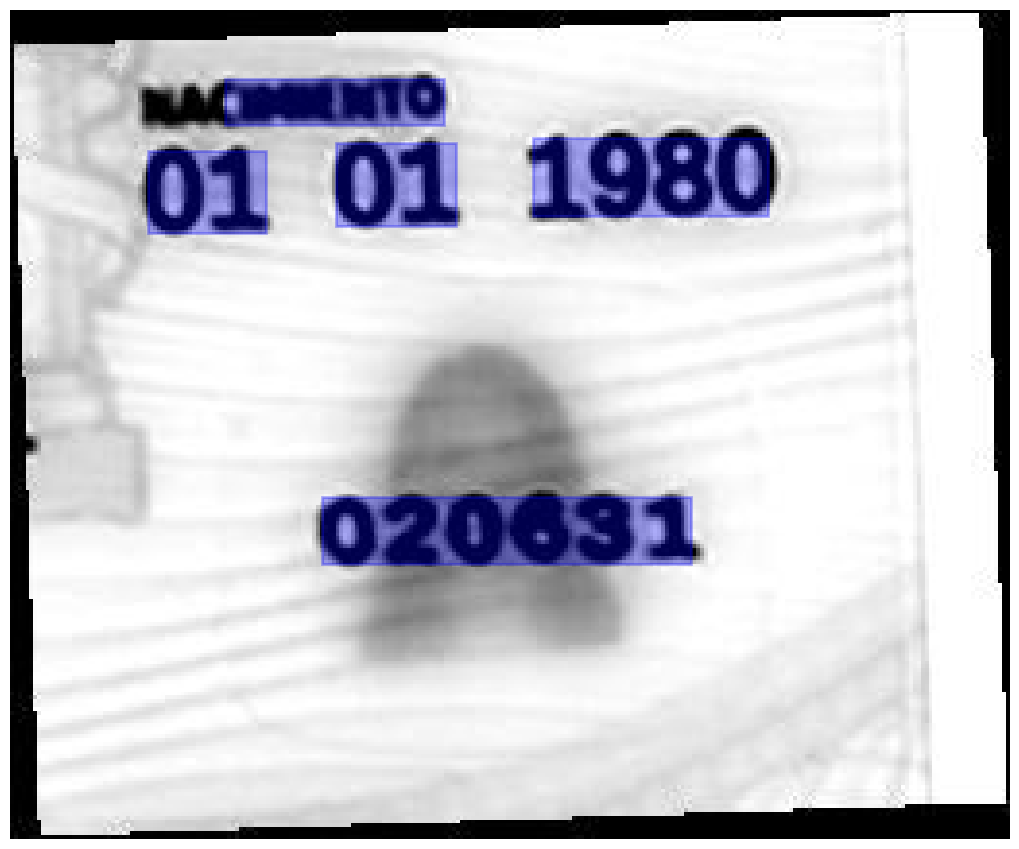


01
01
1980
020631


In [13]:
text_front = extract_text(model, './dni_fotos/front.jpg', angulo=2, algoritmo=Image.Resampling.BICUBIC, idCorte=7)
show_ocr_result(text_front)

* Ejemplo de la extracción de los datos:

In [14]:
path = "./dni_fotos/front.jpg"
nombre_completo = leerDatos(path)

if nombre_completo != "":
    for key, value in nombre_completo.items():
        print(f"{key}: {value}")


dni: 99999999R
nombre_completo: {'nombre': 'CARMEN', 'apellido1': 'ESPANOLA', 'apellido2': 'ESPANOLA'}
sexo: F
nacionalidad: ESP
fecha_nacimiento: 1980-01-01
fecha_emision: 2021-06-02
fecha_validez: 2031-06-02
num_soporte: CAA000000


Y ahora se comparará con los datos de la parte trasera. Creando las funciones ``leerDatosAtras(MRZ)``, que dado un MRZ extrae los datos en sus campos correspondientes. Y `compararDatos(datosAtras, datosDelante)` que compara los diccionarios y devuelve True por cada campo que sea igual.

In [15]:
def leerDatosAtras(MRZ):
    nombreEntero = MRZ["linea3"].split("<<")
    apellidos = nombreEntero[0].split("<")
    nombre = nombreEntero[1]

    if len(apellidos) > 1:
        nombreCompleto = {
            "nombre": nombre,
            "apellido1": apellidos[0],
            "apellido2": apellidos[1]
        }
    else:
        nombreCompleto = {
            "nombre": nombre,
            "apellido1": apellidos[0],
            "apellido2": ""
        }
    
    datosAtras = {
        "dni": MRZ["linea1"][15:24],
        "nombre_completo": nombreCompleto,
        "sexo": MRZ["linea2"][7:8],
        "nacionalidad": MRZ["linea2"][15:18],
        "fecha_nacimiento": MRZ["linea2"][0:6],
        "fecha_validez": MRZ["linea2"][8:14],
        "num_soporte": MRZ["linea1"][5:14]
    }

    return datosAtras

def compararDatos(datosAtras, datosDelante):
    comparacion = {
        "dni": datosAtras["dni"] == datosDelante["dni"],
        "nombre_completo": datosAtras["nombre_completo"] == datosDelante["nombre_completo"],
        "sexo": datosAtras["sexo"] == datosDelante["sexo"],
        "nacionalidad": datosAtras["nacionalidad"] == datosDelante["nacionalidad"],
        "fecha_nacimiento": datosAtras["fecha_nacimiento"] == datosDelante["fecha_nacimiento"].strftime("%y%m%d"),
        "fecha_validez": datosAtras["fecha_validez"] == datosDelante["fecha_validez"].strftime("%y%m%d"),
        "num_soporte": datosAtras["num_soporte"] == datosDelante["num_soporte"]
    }

    return comparacion
 

* Ejemplo:

In [16]:
atras = leerDatosAtras(leerMRZ("./dni_fotos/back.jpg"))
delante = leerDatos("./dni_fotos/front.jpg")

comp = compararDatos(atras, delante)

for key, value in comp.items():
    print(f"{key}: {value}")

dni: True
nombre_completo: True
sexo: True
nacionalidad: True
fecha_nacimiento: True
fecha_validez: True
num_soporte: True


## Comprobaciones Extra
- Comprobación de la caducidad del DNI y detección de caducidad en periodo <3 meses

In [17]:
def comprobar_caducidad(fecha_validez):
    hoy = date.today()
    vigor = False
    caducidadPronto = False

    if fecha_validez > hoy:
        vigor = True
    
    margen_3_meses = hoy + timedelta(days=90)
    if fecha_validez <= margen_3_meses:
        caducidadPronto = True
    
    checks = {
        "vigor": vigor,
        "caducidadPronto": caducidadPronto
    }

    return checks

- Comprobar letra del DNI

In [18]:
def comprobar_letra_dni(dni_str):
    letra_correcta = {"letra_correcta": False}
    # Longitud => 8 números y 1 letra
    if len(dni_str) != 9:
        return letra_correcta
        
    numeros = dni_str[:8]
    letra_proporcionada = dni_str[8].upper()
    
    # Letras oficiales DNI 
    letras_validas = "TRWAGMYFPDXBNJZSQVHLCKE"
    
    try:
        # Calculamos el módulo 23
        indice = int(numeros) % 23
        letra_calculada = letras_validas[indice]
        
        letra_correcta["letra_correcta"] = letra_proporcionada == letra_calculada

        return letra_correcta
    except ValueError:
        # Si los primeros 8 caracteres no son números
        return letra_correcta

- Comprobar que la fecha de la emisión esté entre la fecha de nacimiento y la fecha de validez

In [19]:
def comprobar_coherencia_fechas(fecha_nacimiento, fecha_emision, fecha_validez):
    coherencia_fechas = {"coherencia_fechas": False}
    if fecha_nacimiento <= fecha_emision < fecha_validez:
        coherencia_fechas["coherencia_fechas"] = True
    return coherencia_fechas

- Comprobación formato del número de soporte

In [20]:
def comprobar_formato_soporte(num_soporte):
    resultado = {"numSoporte_Correcto": False}
    
    # Patrón: 3 letras mayúsculas + 6 dígitos
    patron = r"^[A-Z]{3}\d{6}$"
    
    if re.match(patron, num_soporte):
        resultado["numSoporte_Correcto"] = True
        
    return resultado

- Comprobación del periodo de validez (menores de 5 años - validez de 2 años; entre 5 y 30 años - validez de 5 años; entre 30 y 70 años - validez de 10 años; mayores de 70 años - validez permanente (01-01-9999))

In [21]:
def comprobar_periodo_validez(fecha_nacimiento, fecha_emision, fecha_validez):
    resultado = {"periodoValidez_Correcto": False}
    
    edad_emision = fecha_emision.year - fecha_nacimiento.year - ((fecha_emision.month, fecha_emision.day) < (fecha_nacimiento.month, fecha_nacimiento.day))
    
    if edad_emision >= 70:
        if fecha_validez.year >= 9999:
            resultado["periodoValidez_Correcto"] = True
            return resultado
            
    años_validez = fecha_validez.year - fecha_emision.year
    
    if edad_emision < 5:
        validez_esperada = 2
    elif 5 <= edad_emision < 30:
        validez_esperada = 5
    elif 30 <= edad_emision < 70:
        validez_esperada = 10
    else:
        return resultado
        
    if años_validez == validez_esperada:
        resultado["periodoValidez_Correcto"] = True
        
    return resultado

## Exportación a JSON

En este último apartado de la parte de datos, se juntará en un diccionario los datos, sus verificaciones previamente vistas (checksums, consistencia entre la parte frontal y trasera y las comprobaciones extras) y un veredicto final que diga si el DNI es APTO o NO APTO (dependiendo si ha leído exitosamente el DNI o no). Después se exportará a JSON.

In [22]:
atras = leerDatosAtras(leerMRZ("./dni_fotos/back.jpg"))
delante = leerDatos("./dni_fotos/front.jpg")

comp = compararDatos(atras, delante)

In [23]:
verificaciones = {
    "checksums": checksums,
    "validacion_frontal_con_mrz": comp,
    "extras":{
        "caducidad_dni": comprobar_caducidad(delante["fecha_validez"]),
        "letra_dni": comprobar_letra_dni(delante["dni"]),
        "fecha_coherente": comprobar_periodo_validez(delante["fecha_nacimiento"], delante["fecha_emision"], delante["fecha_validez"]),
        "num_soporte": comprobar_formato_soporte(delante["num_soporte"]),
        "periodo_validez": comprobar_periodo_validez(delante["fecha_nacimiento"], delante["fecha_emision"], delante["fecha_validez"])
    }
}

resultado_final = {
    "datos": copy.deepcopy(delante),
    "verificaciones": verificaciones,
    "decision_final": ""
}

# Pasamos a formato string las fechas porque sino da error la librería JSON
resultado_final["datos"]["fecha_nacimiento"] = resultado_final["datos"]["fecha_nacimiento"].strftime("%Y-%m-%d")
resultado_final["datos"]["fecha_emision"] = resultado_final["datos"]["fecha_emision"].strftime("%Y-%m-%d")
resultado_final["datos"]["fecha_validez"] = resultado_final["datos"]["fecha_validez"].strftime("%Y-%m-%d")

# -- COMPROBACIÓN y EXPORTACIÓN a JSON --

In [24]:
# Nombre del archivo de salida
nombre_archivo = "resultado_dni.json"

# Campos completos?
campos_completos = all(value != "" for value in resultado_final["datos"].values())

# Checksums son correctos?
checksums_validos = all(c["correcto"] for c in resultado_final["verificaciones"]["checksums"].values())

# Extras son True?
extras_validos = all(list(e.values())[0] for e in resultado_final["verificaciones"]["extras"].values())

if checksums_validos and extras_validos and campos_completos:
    veredicto = "APTO"
else:
    veredicto = "NO APTO / REVISIÓN MANUAL"

resultado_final["decision_final"] = veredicto


with open(nombre_archivo, 'w') as f:
    json_print = json.dump(resultado_final, f, indent=4)

* Print del JSON:

In [25]:
# Convertimos el diccionario a un string bonito
json_formatted_str = json.dumps(resultado_final, indent=4, ensure_ascii=False)
print(json_formatted_str)

{
    "datos": {
        "dni": "99999999R",
        "nombre_completo": {
            "nombre": "CARMEN",
            "apellido1": "ESPANOLA",
            "apellido2": "ESPANOLA"
        },
        "sexo": "F",
        "nacionalidad": "ESP",
        "fecha_nacimiento": "1980-01-01",
        "fecha_emision": "2021-06-02",
        "fecha_validez": "2031-06-02",
        "num_soporte": "CAA000000"
    },
    "verificaciones": {
        "checksums": {
            "num_docu": {
                "numero": 4,
                "correcto": true
            },
            "fecha_nac": {
                "numero": 4,
                "correcto": true
            },
            "control_final": {
                "numero": 1,
                "correcto": true
            }
        },
        "validacion_frontal_con_mrz": {
            "dni": true,
            "nombre_completo": true,
            "sexo": true,
            "nacionalidad": true,
            "fecha_nacimiento": true,
            "fecha_valid

## 

## Detección de vida con comparación facial

Ahora mediante MediaPipe realizamos la detección de vida en directo. El flujo requiere que el usuario parpadee tres veces y muestre un número aleatorio de dedos frente a la webcam; este proceso asegura que haya una persona real y no una fotografía frente a la cámara. Una vez validados estos gestos, el sistema captura un frame y utiliza la librería DeepFace para comparar la cara de la webcam con la foto extraída del DNI. La comparación emplea el modelo VGG-Face, uno no muy pesado, y la métrica de distancia del coseno para calcular el porcentaje de similitud y verificar la identidad.

### !!! IMPORTANTE
Debido a la naturaleza del código (grabación en directo con la webcam), no es posible dejar constancia (exceptuando el output que deja) del funcionamiento en el NoteBook, por lo cual en el PPTX se expondrá un vídeo con la demo. Lo que si se podrá es demostrar con capturas de pantalla del proceso en el output y una demostración con Deepface (estática) de una imagen nuestra con la foto del DNI.

Iniciando validación: Parpadea 3 veces y luego muestra 3 dedos.


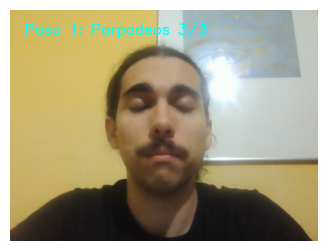

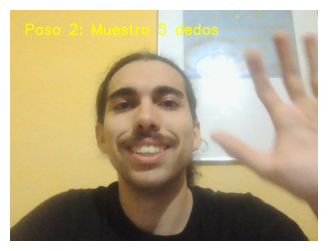

Analizando identidad...
Resultado: True | Similitud: 46.38%


In [5]:
# configuración de mediapipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7)

dedos_map = {
    "thumb": {"tip": mp_hands.HandLandmark.THUMB_TIP.value, "pip": mp_hands.HandLandmark.THUMB_IP.value},
    "index": {"tip": mp_hands.HandLandmark.INDEX_FINGER_TIP.value, "pip": mp_hands.HandLandmark.INDEX_FINGER_PIP.value},
    "middle": {"tip": mp_hands.HandLandmark.MIDDLE_FINGER_TIP.value, "pip": mp_hands.HandLandmark.MIDDLE_FINGER_PIP.value},
    "ring": {"tip": mp_hands.HandLandmark.RING_FINGER_TIP.value, "pip": mp_hands.HandLandmark.RING_FINGER_PIP.value},
    "pinky": {"tip": mp_hands.HandLandmark.PINKY_TIP.value, "pip": mp_hands.HandLandmark.PINKY_PIP.value}
}

cap = cv2.VideoCapture(0)
parpadeos = 0
isBlinking = False
webcamTermina = False
numeroDedos = random.randint(1,5)

def leerFoto(image_file_path: str):
    img = Image.open(image_file_path).convert('L')

    ancho, alto = img.size
    # (inicioX, inicioY, finX, finY)
    img = img.crop((0, alto*0.3, ancho*0.35, alto*1))
    img = ImageEnhance.Contrast(img).enhance(2.0)    
    temp_path = "captura_dni.jpg"
    # Limpiar archivo temporal
    if os.path.exists(temp_path):
        os.remove(temp_path)
    img.save(temp_path)
        
    return image_file_path

print("Iniciando validación: Parpadea 3 veces y luego muestra 3 dedos.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    frame = cv2.flip(frame, 1)
    
    if parpadeos < 3:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results_face = face_mesh.process(rgb_frame)
        if results_face.multi_face_landmarks:
            for face_landmarks in results_face.multi_face_landmarks:
                p_superior = face_landmarks.landmark[159]
                p_inferior = face_landmarks.landmark[145]
                dist = abs(p_superior.y - p_inferior.y)
                
                if dist < 0.012:
                    if not isBlinking:
                        parpadeos += 1
                        isBlinking = True
                        
                        if parpadeos == 3:
                            cv2.putText(frame, f"Paso 1: Parpadeos 3/3", (30, 50), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                            rgb_p = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            fig, ax = plt.subplots(figsize=(4, 3))
                            ax.imshow(rgb_p)
                            ax.axis('off')
                            plt.show()
                else:
                    isBlinking = False
        
        cv2.putText(frame, f"Paso 1: Parpadeos {parpadeos}/3", (30, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    
    else:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results_hands = hands.process(rgb_frame)
        fingers_up = 0
        
        if results_hands.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results_hands.multi_hand_landmarks, results_hands.multi_handedness):
                lado_mano = handedness.classification[0].label 
                for dedo in ["index", "middle", "ring", "pinky"]:
                    tip = hand_landmarks.landmark[dedos_map[dedo]["tip"]]
                    pip = hand_landmarks.landmark[dedos_map[dedo]["pip"]]
                    if tip.y < pip.y: fingers_up += 1
                
                thumb_tip = hand_landmarks.landmark[dedos_map["thumb"]["tip"]]
                thumb_ip = hand_landmarks.landmark[dedos_map["thumb"]["pip"]]
                if(thumb_tip.x < thumb_ip.x and lado_mano == "Right") or (thumb_tip.x > thumb_ip.x and lado_mano == "Left"):
                    fingers_up += 1

        cv2.putText(frame, f"Paso 2: Muestra {numeroDedos} dedos", (30, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        if fingers_up == numeroDedos:
            rgb_f = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            fig, ax = plt.subplots(figsize=(4, 3))
            ax.imshow(rgb_f)
            ax.axis('off')
            plt.show()
            
            cv2.imwrite("captura_persona.jpg", frame)
            webcamTermina = True
            break

    cv2.imshow('Validacion Biometrica Unificada', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

cap.release()
cv2.destroyAllWindows()

if webcamTermina:
    print("Analizando identidad...")
    try:
        resultado = DeepFace.verify(
            img1_path = leerFoto("./dni_fotos/vfront.jpg"), 
            img2_path = "captura_persona.jpg", 
            model_name = "VGG-Face",
            detector_backend = "opencv",
            distance_metric = "cosine"
        )
        similitud = (1 - resultado["distance"]) * 100
        print(f"Resultado: {resultado['verified']} | Similitud: {similitud:.2f}%")
    except Exception as e:
        print(f"Error en matching: {e}")



## Ejemplo comparación con Deepface de manear estática, con imágenes nuestras y de nuestros DNIs:

In [26]:
def compararFotos(img1, img2):
    resultado = DeepFace.verify(
        img1_path = img1, 
        img2_path = img2, 
        model_name = "VGG-Face",
        detector_backend = "opencv",
        distance_metric = "cosine")

    similitud = (1 - resultado["distance"]) * 100
    print(f"Resultado: {resultado['verified']} | Similitud: {similitud:.2f}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    ax1.imshow(im1)
    ax1.axis('off')
    
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
    ax2.imshow(im2)
    ax2.axis('off')

    plt.show()

- Dni Andrea con su foto

Resultado: True | Similitud: 44.35%


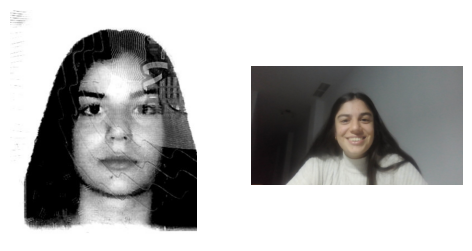

In [27]:
compararFotos("./cara dni/dniAnd.jpg","./cara dni/fotoAnd.jpg")

- Dni Víctor con su foto

Resultado: True | Similitud: 33.23%


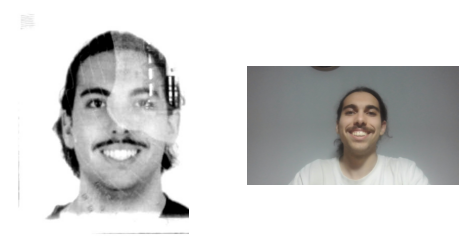

In [28]:
compararFotos("./cara dni/dniVic.jpg","./cara dni/fotoVic.jpg")

- Dni Andrea con foto de Víctor

Resultado: False | Similitud: 14.22%


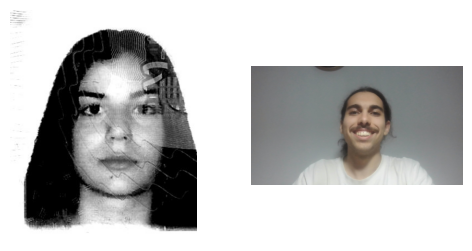

In [29]:
compararFotos("./cara dni/dniAnd.jpg","./cara dni/fotoVic.jpg")

- Dni Víctor con Andrea

Resultado: False | Similitud: 12.87%


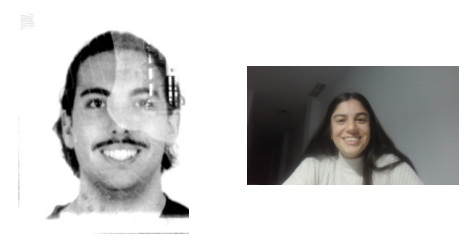

In [30]:
compararFotos("./cara dni/dniVic.jpg","./cara dni/fotoAnd.jpg")